# Navigation Project
Written by Finley Marshall \
Supervisor Philipp Wacker


# Kalman Filters
The Kalman Filter combines noisy sensor data and a prior belief of the system to estimate the current state of the system. The Kalman Filter estimate of the system is often more accurate than just the measurements. The Filter only needs to store the last state, so requires very little memory. This project will focus on using the Kalman Filter to improve the navigation systems of different vehicles.

## Notation
$x_{n}$: The state of the model at time n\
$\hat{x}_{k|n}$: The state estimate at time k, given observations up to time n\
$\boldsymbol{P}_{n}$: The covariance of the state

$\boldsymbol{F}_{n}$: The state transition model

$\boldsymbol{B}_{n}$: The control input model\
$u_{n}$: The control vector

$w_{n}$: The process noise. $w_{n} \sim { \mathcal{N}}(0, Q_{n})$\
$\boldsymbol{Q}_{n}$: The covariance of process noise

$z_{n}$: The observation of the state

$\boldsymbol{H}_{n}$: The observation model\
$v_{n}$: The observation noise. $v_{n} \sim { \mathcal{N}}(0, R_{n})$\
$\boldsymbol{R}_{n}$: The covariance of observations

# Standard Kalman Filter

The current state can be calculated from the last state, the controls and process noise.\
$x_{n} = \boldsymbol{F}_{n}x_{n-1} + \boldsymbol{B}_{n}u_{n} + w_{n}$

The observation of the state can be calculated from the current state and observation noise.\
$z_{n} = \boldsymbol{H}_{n}x_{n}+ v_{n}$

## Predict the next State
Prior of the state\
$\hat{x}_{n|n-1} = \boldsymbol{F}_{n}\hat{x}_{n-1|n-1} + \boldsymbol{B}_{n}u_{n}$

Priori covariance\
$\boldsymbol{P}_{n|n-1} = \boldsymbol{F}_{n}\boldsymbol{P}_{n-1|n-1}\boldsymbol{F}_{n}^{\mathsf{T}} + \boldsymbol{Q}_{n}$

## Update the State given a Measurement

Innovation pre-fit Residual\
$\tilde{y}_{k} = z_{n} - \boldsymbol{H}_{n}\hat{x}_{n|n-1}$

Innovation Covariance\
$\boldsymbol{S}_{n} =  \boldsymbol{H}_{n}\boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}} + \boldsymbol{R}_{n}$

Kalman gain\
$\boldsymbol{K}_{n} = \boldsymbol{P}_{n|n-1}\boldsymbol{H}_{n}^{\mathsf{T}}\boldsymbol{S}_{n}^{-1}$

State estimate\
$\hat{x}_{n|n} = \hat{x}_{n|n-1} + \boldsymbol{K}_{n}\tilde{y}_{n}$

Estimate Covariance\
$\boldsymbol{P}_{n|n} = (\boldsymbol{I} - \boldsymbol{K}_{n} \boldsymbol{H}_{n}) \boldsymbol{P}_{n|n-1}$


The following libraries will be used in this project.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians, pi, sqrt
from helper_functions import *

# Satellite Navigation
The first example will be a satellite orbiting earth, moving in two dimensions $x_{1}$ and $x_{2}$. \
The satellite has an anticlockwise orbit, centered at $(0,0)$, with a start radius. \
The satellite randomly moves from unknown causes, that are drawn from a gaussian distribution with variance $q$.\
This will cause the satellite's radius to change over time. \
Can inaccurately measure the distance to the satellite in the $x_{1}$ dimension every time step, want to accurately estimate the $x_{1}$, $x_{2}$ dimensions. \
The measurements of $x_{1}$ are drawn from a gaussian distribution, with variance $r$. \
The time step is resented as $h$. \
The angle changed every time step is keep constant and know to the model as $a$. 

In [68]:
h = 10
a = (pi * 2) / 360
r = 2
q = 0.1
radius = 10
revolutions = 3
receive_function = always_true

### Initial estimate, $\boldsymbol{X}_{0}$ and Initial covariance, $\boldsymbol{Q}_{0}$
The model starts with no prior information about the satellite position. \
The initial estimate is thus $(0,0)$ with a covariance of the radius. 
\begin{align} 
\boldsymbol{X}_{0} &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\
\\
\boldsymbol{Q}_{0} &= \begin{pmatrix} radius & 0 \\ 0 & radius \end{pmatrix}
\end{align}

### Control input model, $\boldsymbol{B}_{n}$ and Control vector, $u_{n}$
The satellite does not have controls therefore, 
\begin{align} 
\boldsymbol{B}_{n} &= 0 \\
\\
u_{n} &= 0
\end{align}


### State transition model, $\boldsymbol{F}_{n}$

The following equation comes from rotating the 2d plane by $a$ radians anti-clockwise.

\begin{align}
\boldsymbol{X}_{t+1} &= \begin{pmatrix} x_{1}(t+1) \\ x_{2}(t+1) \end{pmatrix} \\
 &= \begin{pmatrix} cos(at) & sin(at) \\ sin(at) & -cos(at) \end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix}
\end{align}


Taking derivatives gives
\begin{align}
\boldsymbol{\dot{X}}_{t} &= \begin{pmatrix} \dot{x}_{1}(t) \\ \dot{x}_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \begin{pmatrix} x_{1}(t) \\ x_{2}(t) \end{pmatrix} \\
 &= \begin{pmatrix} 0 & -a \\ a & 0\end{pmatrix} \boldsymbol{X}_{t}
\end{align}


Using Euler method
\begin{align}
h &= t_{n+1} - t_{n} \\
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t}+h\boldsymbol{\dot{X}}_{t} + w_{n}
\end{align}


Subbing $\boldsymbol{\dot{X}}_{t}$ in

\begin{align}
\boldsymbol{X}_{t+1} &= \boldsymbol{X}_{t} + \begin{pmatrix} 0 & -a \\ a & 0 \end{pmatrix}\boldsymbol{X}_{t}h + w_{n} \\
  &= \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}\boldsymbol{X}_{t} + w_{n}
\end{align}

Thus,
$$
\boldsymbol{F}_{t} = \begin{pmatrix} 1 & -ha \\ ha & 1 \end{pmatrix}
$$



### Observation model, $\boldsymbol{H}_t$
The satellite measures its $x_1$ dimension. So,
$$z_t = x_1 + v_t$$
Using the standard Kalman Filter equation for $z_t$
$$z_{t} = \boldsymbol{H}_{t}x_{t}+ v_{t}$$
Subbing in $z_n $
$$x_1 + v_t = \boldsymbol{H}_{t}\begin{pmatrix} x_{1} \\ x_{2} \end{pmatrix} + v_t $$
Thus, 
$$ \boldsymbol{H}_t = \begin{pmatrix} 1 & 0 \end{pmatrix}$$

### Covariance of the process noise
The Movement Variance is $q$.
The satellite is not moving randomly very much, so $q$ will be quite small. In practice, this value would be obtained from research about the satellite. What is causing the random movements, other satellites and past movements could all give insight into the value for $q$. Once q is obtained,
$$\boldsymbol{Q}_0 = \begin{pmatrix} q & 0 \\ 0 & q \end{pmatrix}$$

### Covariance of the observations
The Measurement Variance is $r$.
In practice, r can be obtained from extensive testing of the equipment used to observe the $x_1$ measurements. The manufacturer of the equipment could also supply the expected performance and variances in different conditions. Once $r$ is obtained,
$$\boldsymbol{R}_0 = \begin{pmatrix} r \end{pmatrix}$$

### Satellite object
Create a satellite \
The $x_1$ and $x_2$ true values are stored in $self.x1$ and $self.x2$ respectively. 
The model receives $z_t = x_1 + v_t$.
$self.x1$, $self.x2$, $self.times$, $self.measurements times$, $self.measurements$ are all used to produce graphs and are not used seen by the model.

In [69]:
class Satellite:
    def __init__(self, a=1, h=1, q=0, r=0, radius=10, start_angle=None):
        self.a = a
        self.h = h
        self.radius = radius
        self.r = r
        self.q = q
        self.x1 = []
        self.x2 = []
        self.times = []
        self.measurements_times = []
        self.current_time = 0
        self.start_angle = start_angle 
        #The start angle is from the $x_1$ positive axis, anti-clockwise
        self.measurements = []

    def __random_start__(self):
        #returns a random start cords for both x1 and x2
        #if the start angle is not given
        if self.start_angle is None:
            self.start_angle = np.random.uniform(2 * pi)

        x1_cord = self.radius * cos(self.start_angle)
        x2_cord = self.radius * sin(self.start_angle)
        return x1_cord, x2_cord

    def next_cord(self, receive=True):
        self.times.append(self.current_time)

        if len(self.x1) == 0:
            x1_cord, x2_cord = self.__random_start__()
            self.x1.append(x1_cord)
            self.x2.append(x2_cord)

            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)

            self.current_time += self.h
            return x1_measurement

        trans_matrix = np.array([[cos(self.a * self.h), -sin(self.a * self.h)],
                                 [sin(self.a * self.h), cos(self.a * self.h)]])
        last_cords = np.array([self.x1[-1], self.x2[-1]])

        x1_cord, x2_cord = np.dot(trans_matrix, last_cords)
        x1_noise, x2_noise = np.random.normal(0, self.q, 2)
        x1_cord += x1_noise
        x2_cord += x2_noise

        self.x1.append(x1_cord)
        self.x2.append(x2_cord)

        if receive:
            x1_measurement = x1_cord + np.random.normal(0, self.r)
            self.measurements.append(x1_measurement)
            self.measurements_times.append(self.current_time)
        else:
            x1_measurement = None

        self.current_time += self.h
        return x1_measurement if receive else None
    
    def graph(self, show=True, title=None):
        #graphs x1, x2 true cords and the measurements of x1
        if title is None:
            title = 'True Values of X1, X2 and Measurements of X1'
        plt.title(title)
        plt.plot(self.measurements_times, self.measurements, '.', label='Measurements')
        plt.plot(self.times, self.x1, label='x1')
        plt.plot(self.times, self.x2, label='x2')
        if show:
            plt.legend(loc='upper left')
            plt.show()

### Kalman Filter object
Create the Kalman Filter
The same notation described in the notation section is used, without the subscript for time.

In [70]:
class KalmanFilter(object):
    def __init__(self, f, h, q, r, p, x, b=0, u=0):
        self.f = f
        self.h = h
        self.q = q
        self.r = r
        self.p = p
        self.x = x
        self.b = b
        self.u = u
        self.n = f.shape[1]

    def predict(self):
        self.x = np.dot(self.f, self.x) + np.dot(self.b, self.u)
        self.p = np.dot(np.dot(self.f, self.p), self.f.T) + self.q
        return self.x

    def update(self, z):
        y = z - np.dot(self.h, self.x)
        s = np.dot(np.dot(self.h, self.p), self.h.T) + self.r
        k = np.dot(np.dot(self.p, self.h.T), np.linalg.inv(s))
        self.x = self.x + np.dot(k,y)
        self.p = np.dot(np.identity(len(self.x)) - np.dot(k, self.h), self.p)
        return self.x

### Average Error
To calculate the average error of the estimates and graph it, need to calculate the average error at each time step. \
Have the average form the last time step, so will use this to save computation.

\begin{align}
 \bar{x}_{n} &=  \frac{\displaystyle \sum_{i=1}^{n}x_{i}}{n} \\
 &= \frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n} + \frac{x_{n}}{n} \\
 &= \frac{n-1}{n}\frac{\displaystyle \sum_{i=1}^{n-1}x_{i}}{n-1} + \frac{x_{n}}{n} \\
 &= \frac{1}{n}((n-1)\bar{x}_{n-1}+x_{n}) 
\end{align}

In [71]:
def average(x, n, a):
    #computes an average from last average a and n indexed at 0 for next item x
    return (n * a + x) / (n + 1)

### Satellite Example Function
The following function assigns all the values of the matrices used in the Kalman Filter as explained before. \
Creates the Kalman Filter and Satellite objects. \
Runs The Kalman Filter for a preset number of revolutions of the Satellite, $3$. \
The prediction and estimate data is stored for graphing and analysis purposes.

In [72]:
def satellite_example(h, a, r, q, radius, revolutions, receive_function, start_angle=None):

    loop_count = loop_size(h, a, revolutions)

    X = np.array([0,0])
    F = np.array([[1, -a * h], [h * a, 1]])
    H = np.array([1, 0]).reshape(1, 2)
    Q = np.array([[q, 0], [0, q]])
    R = np.array([r])
    P = np.array([[radius, 0], [0, radius]])

    kf = KalmanFilter(f=F, h=H, q=Q, r=R, x=X, p=P)
    satellite = Satellite(a=a, h=h, q=q, r=r, radius=radius, start_angle=start_angle)

    prediction_data = []
    estimate_data = []

    for i in range(loop_count):
        receive = receive_function(i)

        z = satellite.next_cord(receive=receive)

        x1, x2 = kf.predict()
        prediction_data.append((x1, x2, kf.p))

        if z is not None:
            x1, x2 = kf.update(z)
            estimate_data.append((x1, x2, kf.p))

    return satellite, prediction_data, estimate_data

In [73]:
satellite, prediction_data, estimate_data = satellite_example(h, a, r, q, radius, revolutions, receive_function)

### Satellite movement
How the satellite is moving in time and what measurements are being observed.

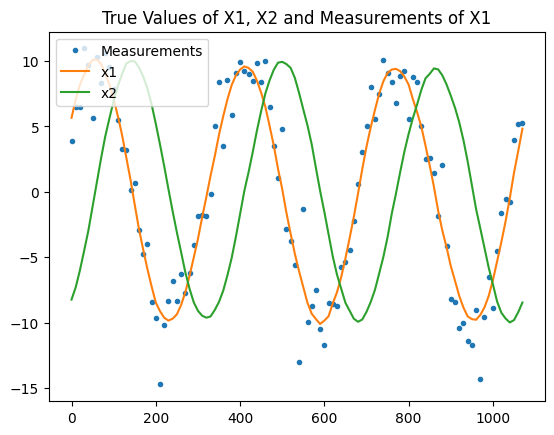

In [74]:
satellite.graph()

### $x_{1}$ Dimension
The true $x_1$ values compared to the estimate of the $x_1$ values from the model. The $99$% confidence interval of the estimate is shown. The lower bound is calculated from subtracting three standard deviations from the estimate. One standard deviation is calculated from the square root off the variance of the $x_1$ estimate. The variance of the $x_1$ estimate is stored in $\boldsymbol{P}_t$. The upper bound is found similarly but adding.


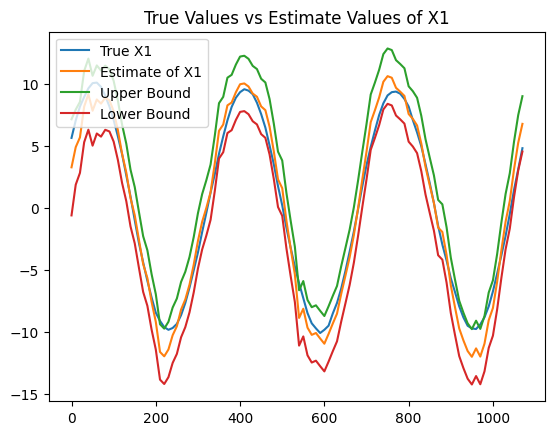

In [75]:
graph_x1_and_p(satellite, prediction_data, estimate_data)

### $x_{2}$ Dimension
The true $x_2$ values compared to the estimate of the $x_2$ values from the model. \
The $99$% confidence interval of the estimate is shown. The confidence interval is calculated the same as the $x_1$ Dimension, using values associated with $x_2$.

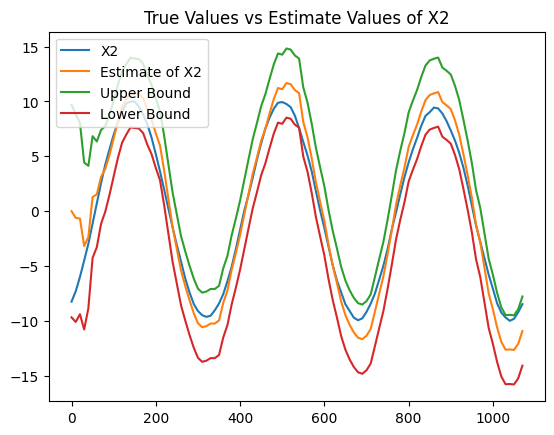

In [76]:
graph_x2_and_p(satellite, prediction_data, estimate_data)

### Error
The different between the measurements, $x_1$ estimates, $x_2$ estimates and their respective true values. \
The measurement error is the true value of $x_1$ minus the observed measurement for $x_1$. \
The $x_1$ error is the true value of $x_1$ minus the estimate for $x_1$.\
The $x_2$ error is the true value of $x_2$ minus the estimate for $x_2$.

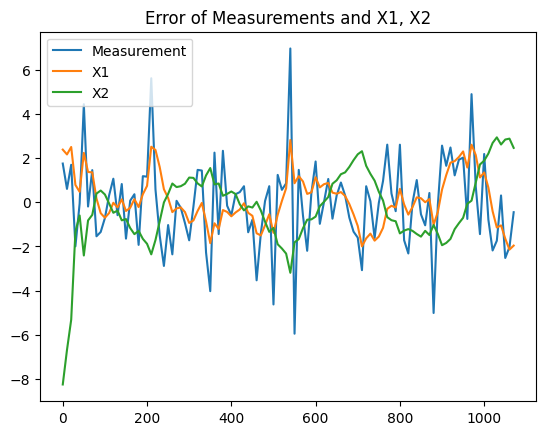

In [77]:
graph_error(satellite, prediction_data, estimate_data)

### Average Distance
The average distance between the measurements, $x_1$ estimates, $x_2$ estimates and their respective true values. \
The measurement error is the distance between the true value of $x_1$ and the observed measurement for $x_1$. \
The $x_1$ error is the distance between the true value of $x_1$ and the estimate for $x_1$.\
The $x_2$ error is the distance between the true value of $x_2$ and the estimate for $x_2$.

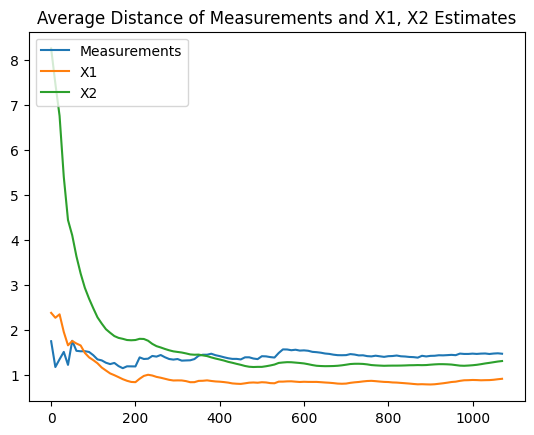

In [78]:
graph_average_error(satellite, prediction_data, estimate_data)

# Analysis

The current examples have used, \
Time step, $h = 10$\
Measurement Variance, $r = 2$\
Movement Variance, $q = 0.1$\
Revolutions of the satellite = $3$ \
\
Will now examine the effect of changing h, r, and q. \
The average distance of the $x_1$ estimate, $x_2$ estimate and measurements of $10000$ satellite objects are calculated over $5$ satellite revolutions. \
Then the desired value is increased, and the average distances are calculated for the new value. 


In [79]:
analysis_satellites = 100
analysis_revolutions = 5

## Time step
The time step, $h$, determines how often the satellite receives a measurement. Increasing the time step results in fewer data points per revolution. Less data should increase the variance of the model and could lead to the model becoming more inaccurate than the measurements. \
Will examine h being $5, 10, 20$. \
The two graphs below show the differences between the number of measurements observed with a time step of 5 and a time step of 20.

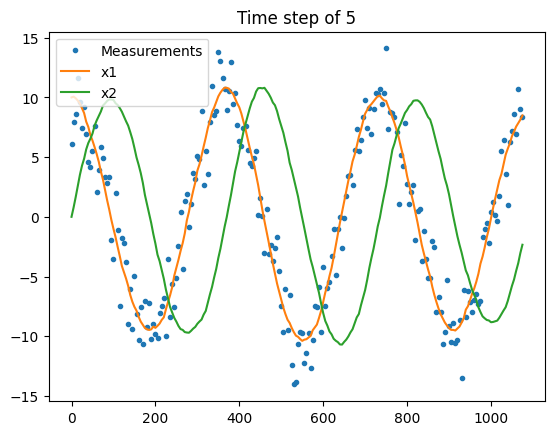

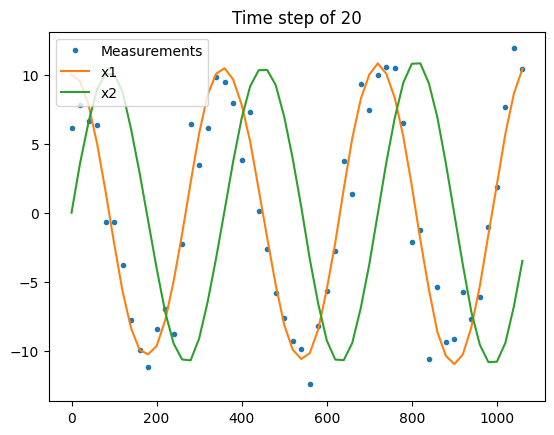

In [80]:
satellite_h_5 = satellite_example(5, a, r, q, radius, revolutions, receive_function, start_angle=0)
satellite_h_20 = satellite_example(20, a, r, q, radius, revolutions, receive_function, start_angle=0)
satellite_h_5[0].graph(title='Time step of 5')
satellite_h_20[0].graph(title='Time step of 20')

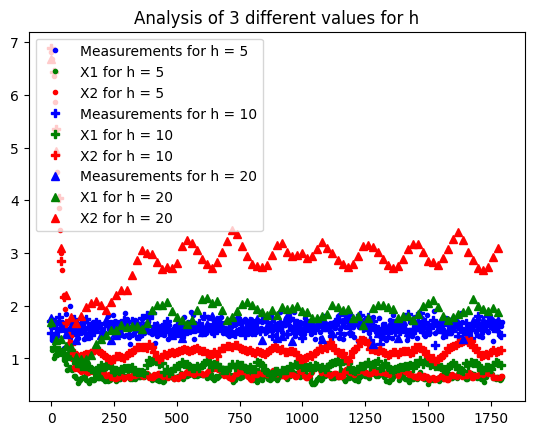

In [81]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [5, 10, 20])

### Time step Results
The above graph shows the average of the distances, for the measurements, $x_1$ estimates and $x_2$ estimates.
On average, the model has a lower distance than the measurements for time steps $5$ and $10$, \
However, the time step of $20$ is too large for the current model, and the model has a larger distance than the measurements.

## Measurement Variance
The variance of the measurement noise, $r$, determines the spread of the measurement values. Increasing $r$ increases the average distance from the true value of $x_1$ to the measurement of $x_1$. The higher the value of $r$ the more noise, has to be filtered out. This can cause the model to not see changes in the movement of the satellite because the movement is perceived as noise. \
Will examine r being $2,4$. \
The two following graphs show the difference between the spread of the measurements, for $r=2$ and $r=4$.

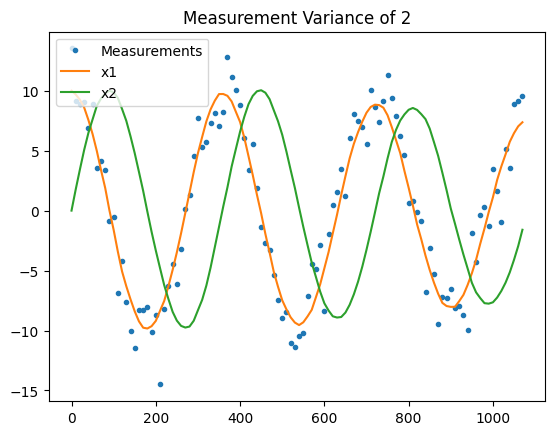

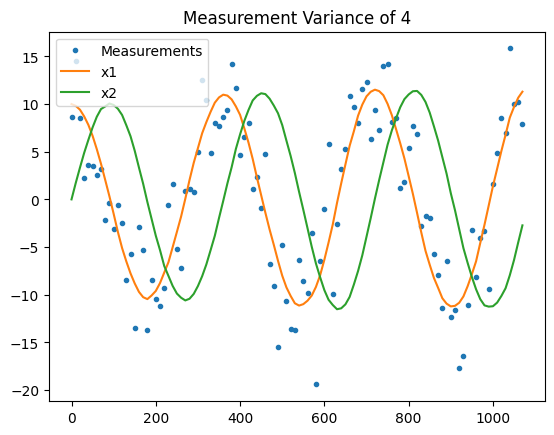

In [82]:
satellite_r_2 = satellite_example(h, a, 2, q, radius, revolutions, receive_function, start_angle=0)
satellite_r_4 = satellite_example(h, a, 4, q, radius, revolutions, receive_function, start_angle=0)
satellite_r_2[0].graph(title='Measurement Variance of 2')
satellite_r_4[0].graph(title='Measurement Variance of 4')

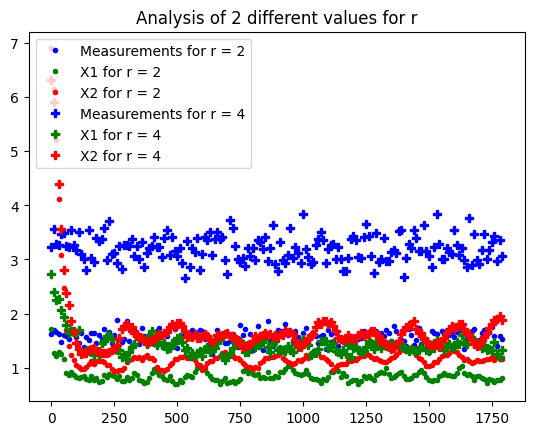

In [83]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'r', [2, 4])

### Measurement Variance Results
The model preforms better than the measurements for both values of r. The average distance for $x_1$ and $x_2$ is roughly half of the average measurement distance for both values of $r$. The model is able to maintain a low distance under high values of measurement variance.


## Movement Variance
The movement variance, $q$, determines how much random movement occurs to the satellite. Increasing the movement variance results in the satellite movement becoming more random, and harder to track accuracy. If $q$ is too large, the model will not be able to predict the random satellite movement and the model will be less accurate than the measurements.\ 
Will examine q being $0.1, 0.2, 0.4$.\
The two following graphs show the difference between the satellite movement, for $q=0.1$ and $q=0.4$.

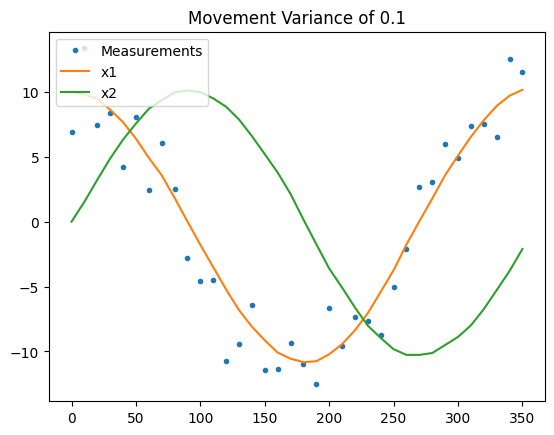

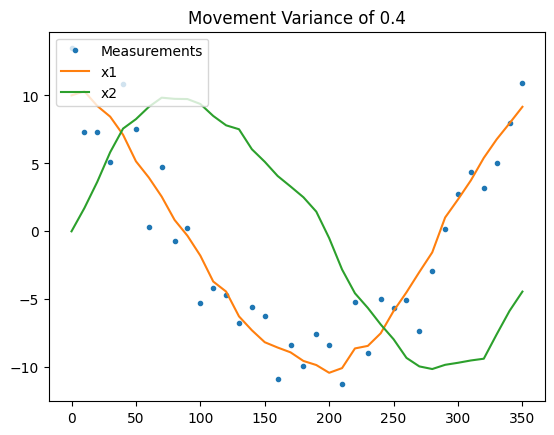

In [84]:
satellite_q_01 = satellite_example(h, a, r, .1, radius, 1, receive_function, start_angle=0)
satellite_q_04 = satellite_example(h, a, r, .4, radius, 1, receive_function, start_angle=0)
satellite_q_01[0].graph(title='Movement Variance of 0.1')
satellite_q_04[0].graph(title='Movement Variance of 0.4')

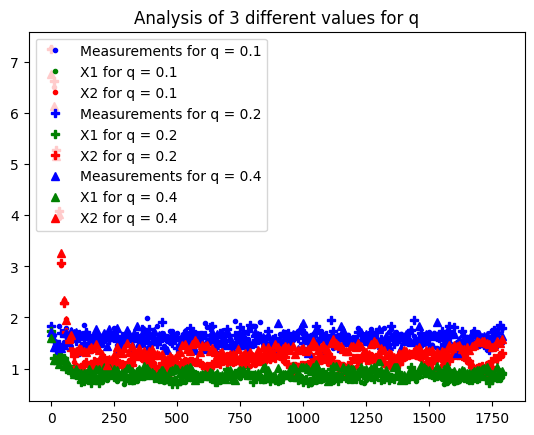

In [85]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'q', [.1, .2, .4])

### Movement Variance Results
The model has a lower distance for $x_1$, $x_2$ than the measurement distance for all values of $q$. The model is able to preform under high values of movement variance, such as $0.4$, which results in a large amount of random movement. 

# Unreliable observations of Measurements
It is not realistic to assume every time step a new measurement will be available to use. \
Can change the model by changing the receive_function. \
If the function returns $True$, a new measurement will be observed, the Kalman Filter will continue as before. \
If the function returns $False$, the Kalman filter will run the prediction step but not the update step and the estimate will be the prediction.

## Create a Satellite with observations every second time step.
In the analysis of the time step, the observations were more accurate than the measurements with a time step of 20. \
Use unreliable observations to improve the model for this time step.
Satellite A. \
A satellite with a time step of 20, and observes a measurement every time step. The same as in the analysis of the time step.\
Satellite B. \
A satellite with the time step to 10 and observes a measurement every second time step. \
The satellites will behave the exact same, but the models will be different. Will compare the two models, to determine the more accuracy one.

In [94]:
def every_second(i):
    return i % 2 == 0

satellite_A = satellite_example(20, a, r, q, radius, 1, always_true, start_angle=0)
satellite_B = satellite_example(10, a, r, q, radius, 1, every_second, start_angle=0)

### Compare the two satellites' movements and measurements
The graphs will be slightly different because of the random behaviour of the satellites.

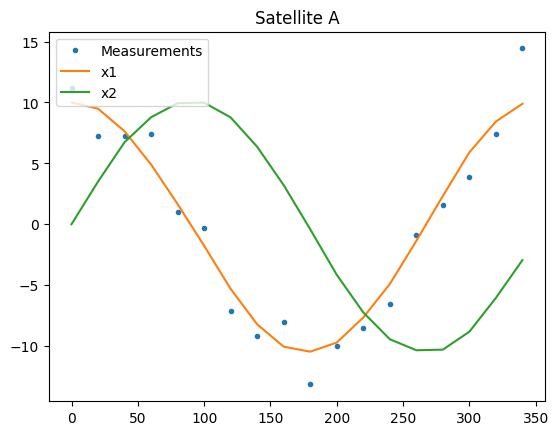

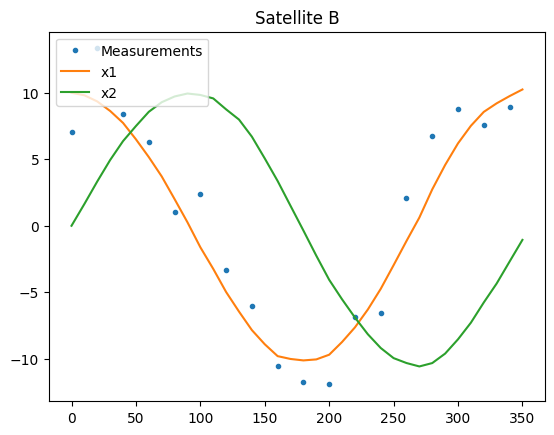

In [95]:
satellite_A[0].graph(title='Satellite A')
satellite_B[0].graph(title='Satellite B')

### Analysis of the two satellites
The average distance for $x_1$, $x_2$ and the measurements from their respective true values are calculated for $10000$ satellites over $5$ revolutions. \
Satellite A has $h=20$ and Satellite B has $h=10$.

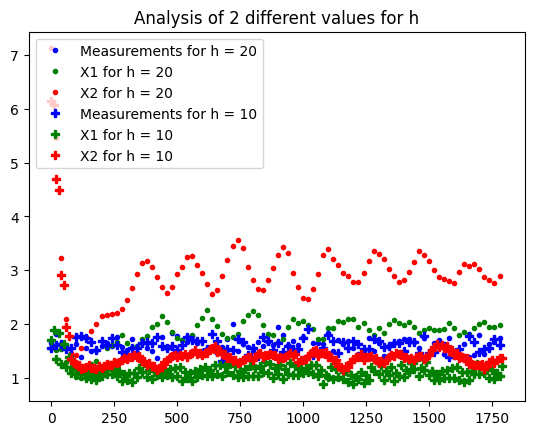

In [96]:
satellite_analysis(analysis_satellites, analysis_revolutions, 'h', [20, 10], receive_values=[always_true, every_second])

## Unreliable observations of Measurements Results
Satellite A, $h=20$, behaviours the same as in the analysis step, preforming worse than the measurements.\
Satellite B, $h=10$, preforms better than the measurements and significantly better that Satellite A. \
The change to the model has resulted in a significant increase in accuracy. \
With more analysis, the different time steps for this example could be explored and their performance measured. Finding an optimal time step, given the time between measurements, could also be studied.

# Satellite Conclusion 
The Kalman Filter model tracks a satellite in real time, using a two-stage filter. The model predicts the next state and updates the state if a measurement is observed. The model was tested using randomly generated satellites and allowed the $x_1$ and $x_2$ coordinates to be inferred from noisy $x_1$ measurements. The model requires no prior information about the start state of the satellite, thus can be used on any satellite. The performance was not significantly changed under large movement variance or large measurement variance. Unreliable measurements can also be used to increase the model performance for large time steps. 